In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import missingno as msng
import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv("Data/train.csv")

In [38]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
df = df.drop(columns = ['Cabin', 'PassengerId'], axis = 1)

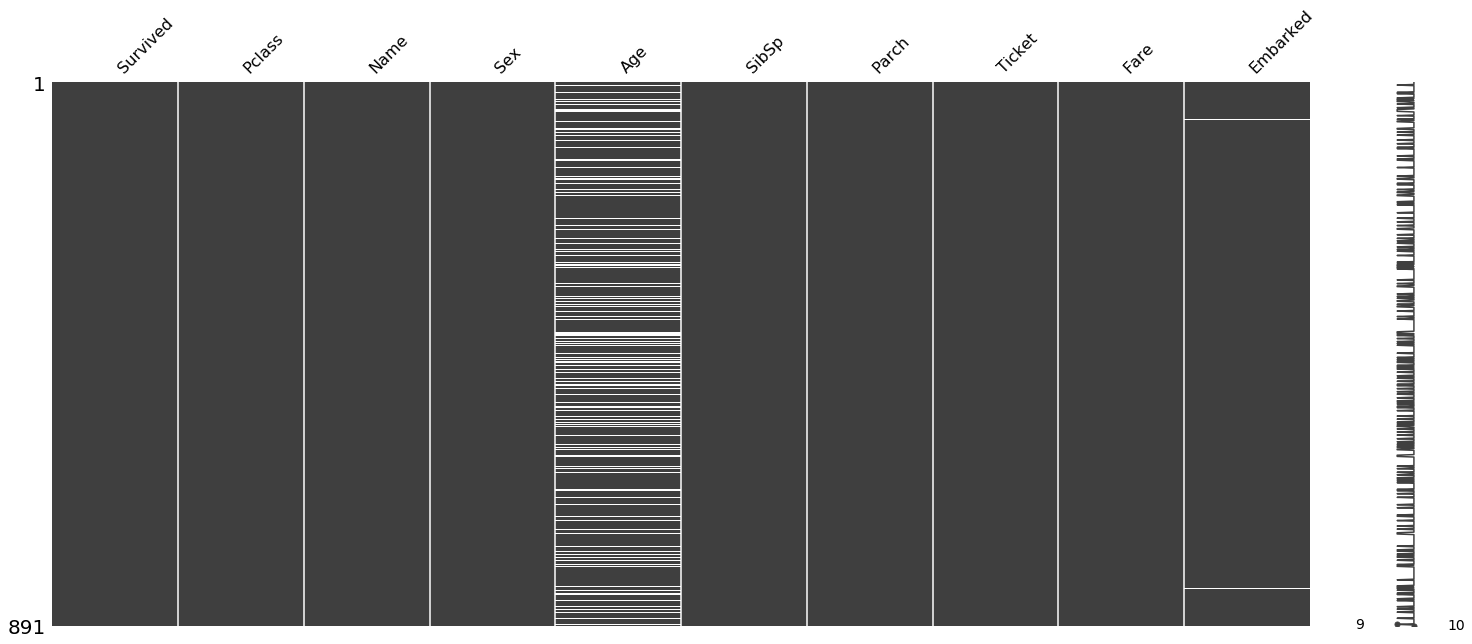

In [40]:
msng.matrix(df)

In [41]:
df.shape

(891, 10)

In [42]:
df['Embarked'].fillna(df['Embarked'].value_counts().index[0], inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
df_train, df_val = train_test_split(df, test_size = 0.3)

In [58]:
def df_to_dataset(dataframe, batch_size = 5):
    df = dataframe.copy()
    labels = df.pop('Survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.batch(batch_size)
    return ds 

In [59]:
train_dataset = df_to_dataset(df_train)
val_dataset = df_to_dataset(df_val)

In [49]:
train_dataset

<BatchDataset shapes: ({Pclass: (None,), Name: (None,), Sex: (None,), Age: (None,), SibSp: (None,), Parch: (None,), Ticket: (None,), Fare: (None,), Embarked: (None,)}, (None,)), types: ({Pclass: tf.int32, Name: tf.string, Sex: tf.string, Age: tf.float64, SibSp: tf.int32, Parch: tf.int32, Ticket: tf.string, Fare: tf.float64, Embarked: tf.string}, tf.int32)>

In [60]:
for feature_batch, label_batch in train_dataset.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['Age'])
    print('A batch of targets:', label_batch )

Every feature: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
A batch of ages: tf.Tensor([31. 31. 44. 60. 25.], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int32)


In [51]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [67]:
feature_columns = []

numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']
for column in numerical_columns:
    feature_columns.append(tf.feature_column.numeric_column(column))

sex = tf.feature_column.categorical_column_with_vocabulary_list(
        'Sex', ['male', 'female'])
sex_one_hot = tf.feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

embarked = tf.feature_column.categorical_column_with_vocabulary_list(
            'Embarked', ['C', 'Q', 'S'])
embarked_one_hot = tf.feature_column.indicator_column(embarked)
feature_columns.append(embarked_one_hot)

pclass = tf.feature_column.categorical_column_with_vocabulary_list(
            'Pclass', [1, 2, 3])
pclass_one_hot = tf.feature_column.indicator_column(pclass)
feature_columns.append(pclass_one_hot)

In [68]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [72]:
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer = 'adam',
             loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics = ['accuracy'])

model.fit(train_dataset,
         validation_data = val_dataset,
         epochs = 5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/5
125/125 [==============================] - 1s 7ms/step - loss: 0.7120 - accuracy: 0.6661 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
125/125 [==============================] - 0s 2ms/step - loss: 0.5856 - accuracy: 0.7030 - val_loss: 0.6433 - val_accuracy: 0.6381
Epoch 3/5
125/125 [==============================] - 0s 2ms/step - loss: 0.5598 - accuracy: 0.7191 - val_loss: 0.7127 - val_accuracy: 0.6604
Epoch 4/5
125/125 [==============================] - 0s 2ms/step - loss: 0.51

## Testing

In [73]:
df_test = pd.read_csv('Data/test.csv')

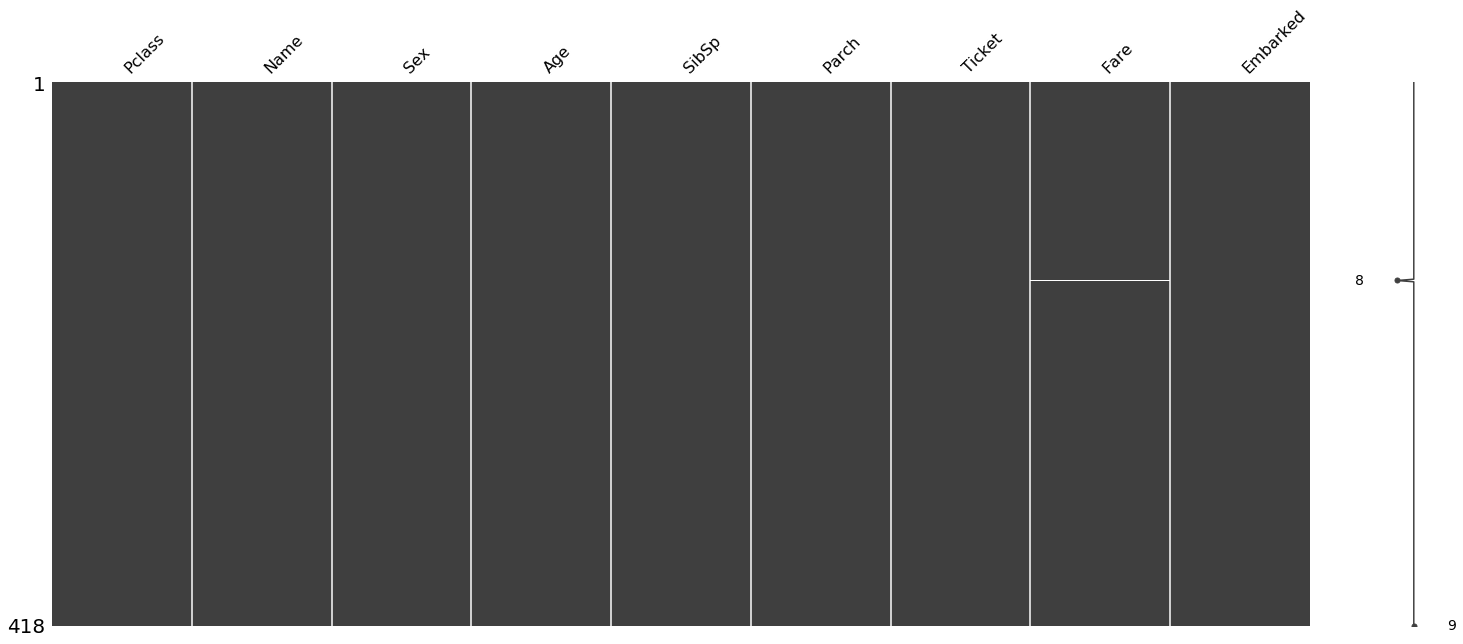

In [76]:
msng.matrix(df_test)

In [75]:
df_test = df_test.drop(columns = ['Cabin', 'PassengerId'], axis = 1)
df_test['Embarked'].fillna(df_test['Embarked'].value_counts().index[0], inplace = True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace = True)

In [77]:
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace = True)

In [78]:
df_test_target = pd.read_csv('Data/gender_submission.csv')

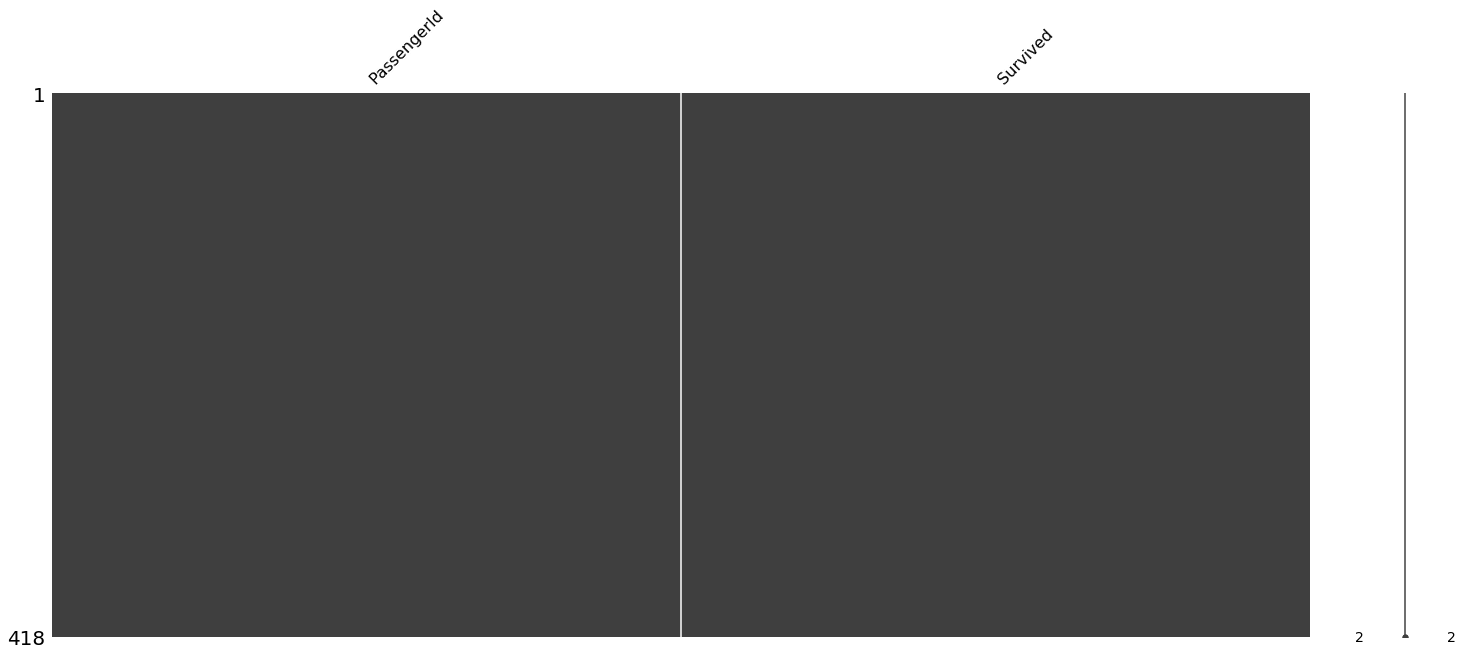

In [84]:
msng.matrix(df_test_target)

In [85]:
df_test.shape, df_test_target.shape

((418, 9), (418, 2))

In [90]:
df_test_full = pd.concat([df_test, df_test_target], axis = 1)

In [91]:
df_test_full.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,PassengerId,Survived
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,892,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,893,1
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,894,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,895,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,896,1


In [92]:
test_dataset = df_to_dataset(df_test_full)

In [93]:
loss, accuracy = model.evaluate(test_dataset)
print('Accuracy: ', accuracy)

84/84 [==============================] - 0s 3ms/step - loss: 0.3651 - accuracy: 0.7632
Accuracy:  0.7631579
